<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<img src='../../pics/banner.PNG'/>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum Computer Vision</h1>

<h2>Doel: Image Processing voor het vereenvoudigen van <i>Features</i></h2>

<img src='../../pics/land_use.png' length=40% width=40%>

<h3>Imports</h3>

In [26]:
from image_filter import ImageFilter
from my_image_filter import MyImageFilter
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random
import skimage.measure
import scipy as sp

<h3>Globale variabelen</h3>

In [27]:
riverDirectory = '../../pics/2750/River'
highwayDirectory = '../../pics/2750/Highway'

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://www.kaggle.com/datasets/apollo2506/eurosat-dataset">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=50% width=50%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

<h3>Data Selection</h3>


In [28]:
edgeFiles = list()
 
for filename in os.listdir(riverDirectory):
    imgFile = os.path.join(riverDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

<h3>Exercise 1</h3>
<p>
    Voeg de directory Highway toe aan de <u>list</u> edgeFiles zodat ook de Highway images worden meegenomen. 
</p>

In [29]:
# Oplossing 
riverDirectory = '../../pics/2750/River'
highwayDirectory = '../../pics/2750/Highway'
edgeFiles = []

for filename in os.listdir(riverDirectory):
    imgFile = os.path.join(riverDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

for filename in os.listdir(highwayDirectory):
    imgFile = os.path.join(highwayDirectory, filename)

    if ".jpg" in imgFile:
        edgeFiles.append(imgFile)

#print(edgeFiles)


<h3>Data Transform</h3>
<p>
Image filters zijn Tensors en om die toe te kunnen passen zetten we de images eerst om naar Tensors m.b.v. Numpy.
</p>    

In [30]:
imageTensors = [ plt.imread(pic).astype(float) for pic in edgeFiles ]
nrOfImages = len(imageTensors)

<h4>Data Normalising</h4>
<p>Om waardes tussen 0 en 1 te vergrijgen, delen we door de maximale pixelwaarde</p>

In [31]:
imageTensors = [ imageTensor/255 for imageTensor in imageTensors ]

<p>
De tensors bevatten alleen de numerieke data van de images, om die te kunnen herleiden tot de oorspronkelijke images hebben we ook een lijst met de corresponderende labels nodig. De labels kunnen we afleiden uit de bestandsnamen.    
</p>    

In [32]:
labelNames, labelNumbers = ([], [])

for i, fileName in enumerate(edgeFiles):
    labelNames.append(fileName.split('/')[4])
    labelNumbers.append(i)
    # waarbij [5] de 5e slash is die je weghaalt. Nu moet je de .jpg nog verwijderen.
print(labelNames[0])  
print(edgeFiles[0]) 

River\River_1.jpg
../../pics/2750/River\River_1.jpg


**Controleer de data**

In [33]:
print(f"De eerste Image heeft label {labelNames[0]}")
print(f"De laatste Image heeft label {labelNames[nrOfImages-1]}")

De eerste Image heeft label River\River_1.jpg
De laatste Image heeft label Highway\Highway_999.jpg


<h3>Data visualiseren</h3>

In [34]:
def showImages():
    
    plt.figure(figsize=(10,10))
    
    for i in range(4):
        
        # Maak een 2 x 2 raster van Images
        plt.subplot(2, 2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)        
                
        # Van Tensor terug naar Image
        plt.imshow(imageTensors[i])
        
        # Bijbehorende Imagelabel
        plt.xlabel( f"{labelNames[labelNumbers[i]]} {labelNumbers[i]}" ) 

    plt.show()           

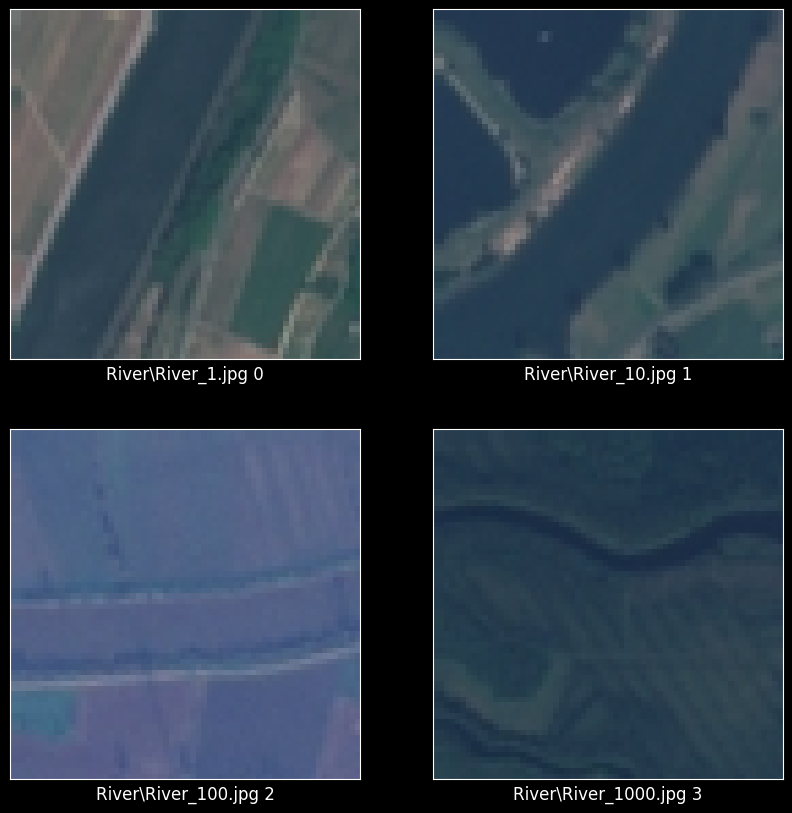

In [35]:
showImages() 

<h3>Exercise 2</h3>
<p>
Maak een nieuwe functie <u>showRandomImages()</u> die <u>16 random</u> images uit de dataset selecteert en weergeeft in een 4 x 4 raster<br>
<strong>Let erop dat bij iedere image het corresponderende label getoond wordt</strong>
</p>

In [36]:
# Oplossing
def showRandomImages():
    random.shuffle(edgeFiles)  # Randomize the order of the image files

    selected_images = edgeFiles[:16]  # Select the first 16 images from the randomized list

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))  # Create a 4 x 4 grid of subplots

    for i, image_path in enumerate(selected_images):
        img = mpimg.imread(image_path)  # Read the image
        label = os.path.basename(image_path)  # Get the label from the image path

        row = i // 4  # Calculate the row index of the subplot
        col = i % 4  # Calculate the column index of the subplot

        axs[row, col].imshow(img)
        axs[row, col].set_title(label)  # Set the title as the image label
        axs[row, col].axis('off')  # Turn off axis labels

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()  # Display the grid of images


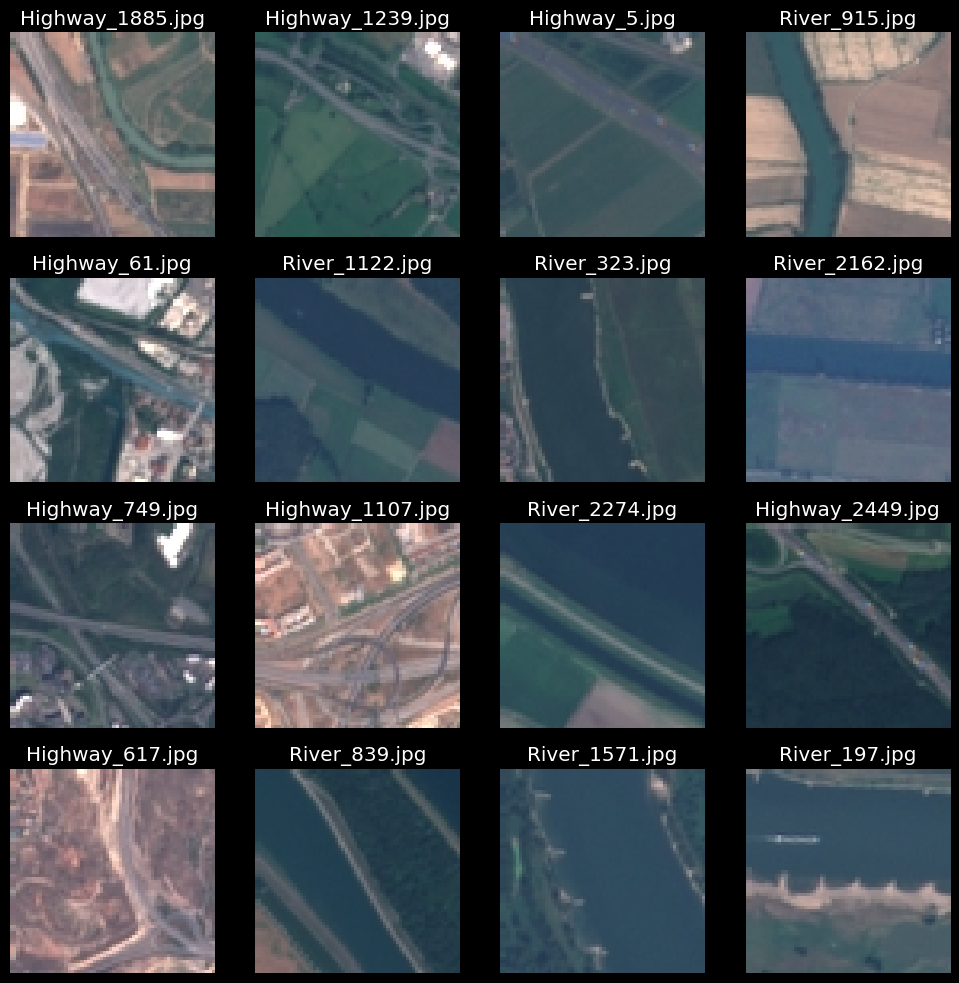

In [37]:
# Call the function to show the random images
showRandomImages()

<h4>Edge Detection</h4>
<p>
Zowel de Highway en River Images hebben randen die relevant zijn om de auto- of waterweg te kunnen onderscheiden van de directe omgeving. We gaan daarom zoveel mogelijk niet-relevante informatie wegfilteren.    
</p>    

<p>Functie voor het genereren van een subplot</p>

In [38]:
def plotImgs(lImg, rImg):
    plt.style.use('dark_background') 
    plt.rcParams["font.size"] = 12
    plt.rcParams["figure.figsize"] = (12, 7)

    fig, (axL, axR) = plt.subplots(ncols=2, constrained_layout=True)
    fig.suptitle(f"{labelNames[labelNumbers[randInd]]} {labelNumbers[randInd]}")
    imL = axL.imshow(np.clip(lImg, 0, 1), interpolation="none")
    imR = axR.imshow(np.clip(rImg, 0, 1), interpolation="none")    

**Definieer de Image Kernel voor de convolutiefiler**

In [39]:
isoTropicFilter = ImageFilter( 
    np.array (
        [
            [-1, -1, -1], 
            [-1,  8, -1], 
            [-1, -1, -1]
        ]
    ) 
)

# Call the function to show the random images
#isoTopic wil zeggen rotation invariant. Linksom of rechsom draaien geeft hetzelfde resultaat.

**Filter de Image**

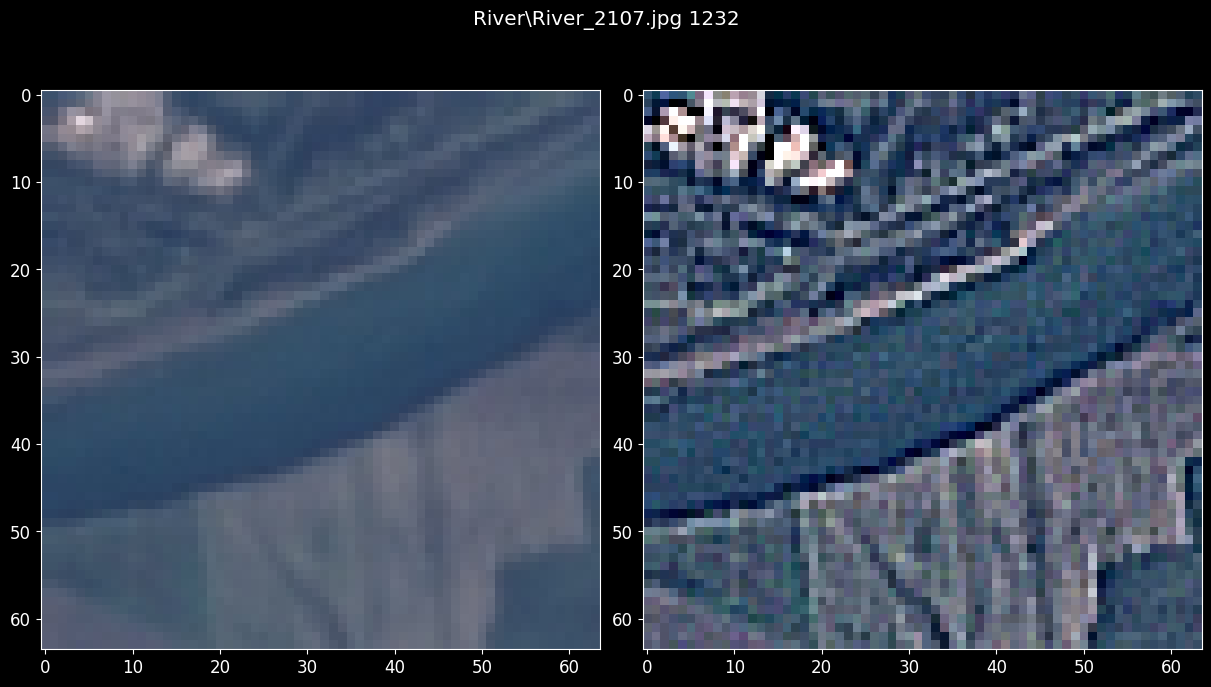

In [40]:
randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[randInd]
imgFiltered = isoTropicFilter.convolve(imgOrg)

plotImgs(imgOrg, (imgFiltered+imgOrg))

<h3>Exercise 3</h3>
<p>
    Maak een 3x3 ImageFilter object <u>horEdgeFilter</u> en voer daarmee een aantal Convoluties uit.<br> 
    Vergelijk de resultaten met die van de Convoluties met de <u>isoTropicFilter</u>
</p>
<p>
    <strong>Tips</strong>
    <ul>
        <li>Op <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing">Wikipedia</a> kun je verschillende filters vinden.</li>
        <li>Schrijf een functie voor <i>batchverwerking</i> op Images.</li>
    </ul>
</p>

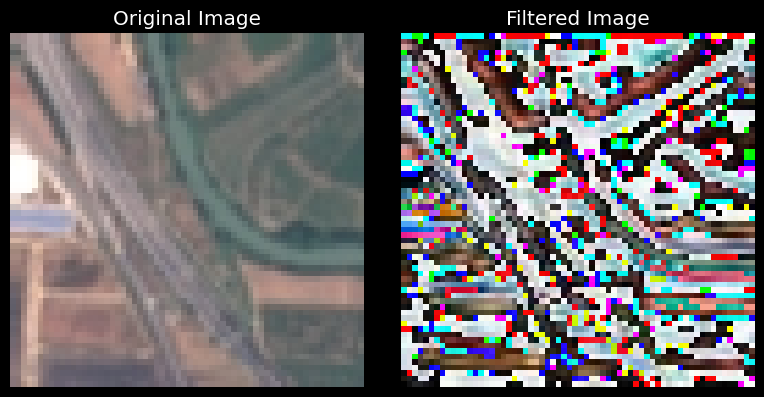

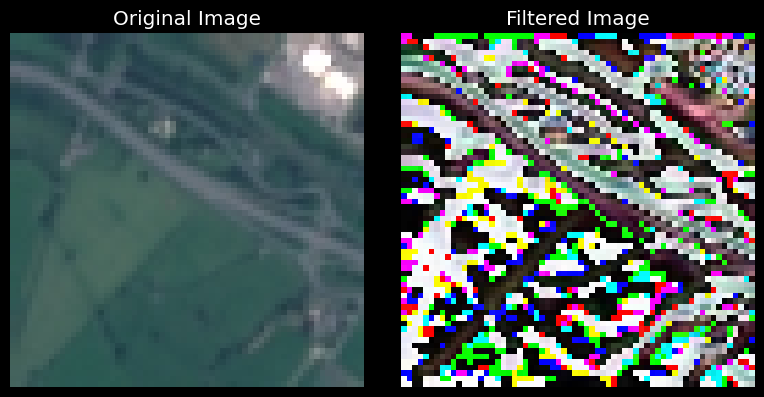

In [41]:
# Create the horizontal edge filter
horEdgeFilter = ImageFilter([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])
def batchProcessImages(image_files, filter_obj, num_examples):
    processed_examples = 0

    for image_path in image_files:
        if processed_examples >= num_examples:
            break

        img = Image.open(image_path)
        img_array = np.array(img)  # Convert the image to a NumPy array
        filtered_img = filter_obj.convolve(img_array)
        
        # Display the original and filtered images
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img)
        axs[0].set_title('Original Image')
        axs[0].axis('off')
        
        axs[1].imshow(filtered_img)
        axs[1].set_title('Filtered Image')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()

        processed_examples += 1


# Call the batchProcessImages() function with the desired number of examples (2 in this case)
batchProcessImages(edgeFiles, horEdgeFilter, num_examples=2)
#batchProcessImages(edgeFiles, horEdgeFilter)



<h3>Exercise 4</h3>
<p>
Voeg aan class ImageFilter de methode <u>downSample()</u> toe waarmee een Image gedownsampled kan worden. Maak gebruik van <a href="https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.block_reduce">block_reduce</a> met een grootte van 2.
</p>

In [42]:
MyImageFilter(isoTropicFilter)

In [43]:
myIsoTropicFilter = MyImageFilter( 
    np.array (
        [
            [-1, -1, -1], 
            [-1,  8, -1], 
            [-1, -1, -1]
        ]
    ) 
)

In [44]:
myPoolFilter = MyImageFilter()

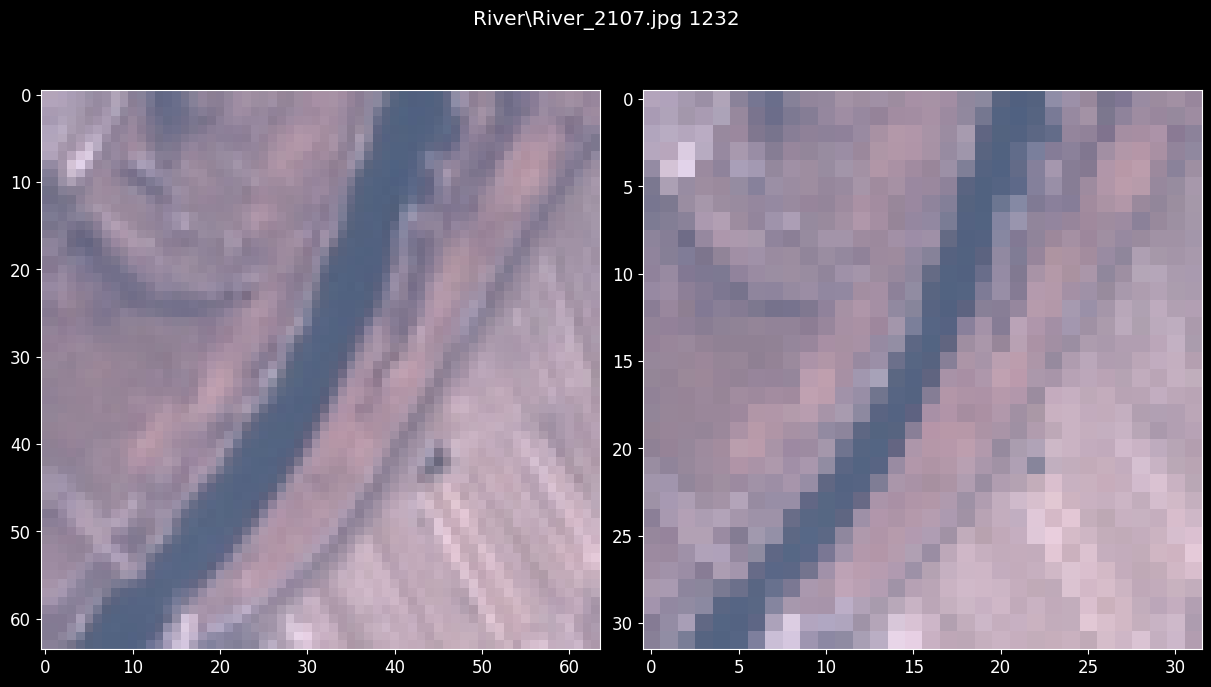

In [45]:
# randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[42]
imgFiltered = myIsoTropicFilter.downSample(imgOrg)

plotImgs(imgOrg, imgFiltered)

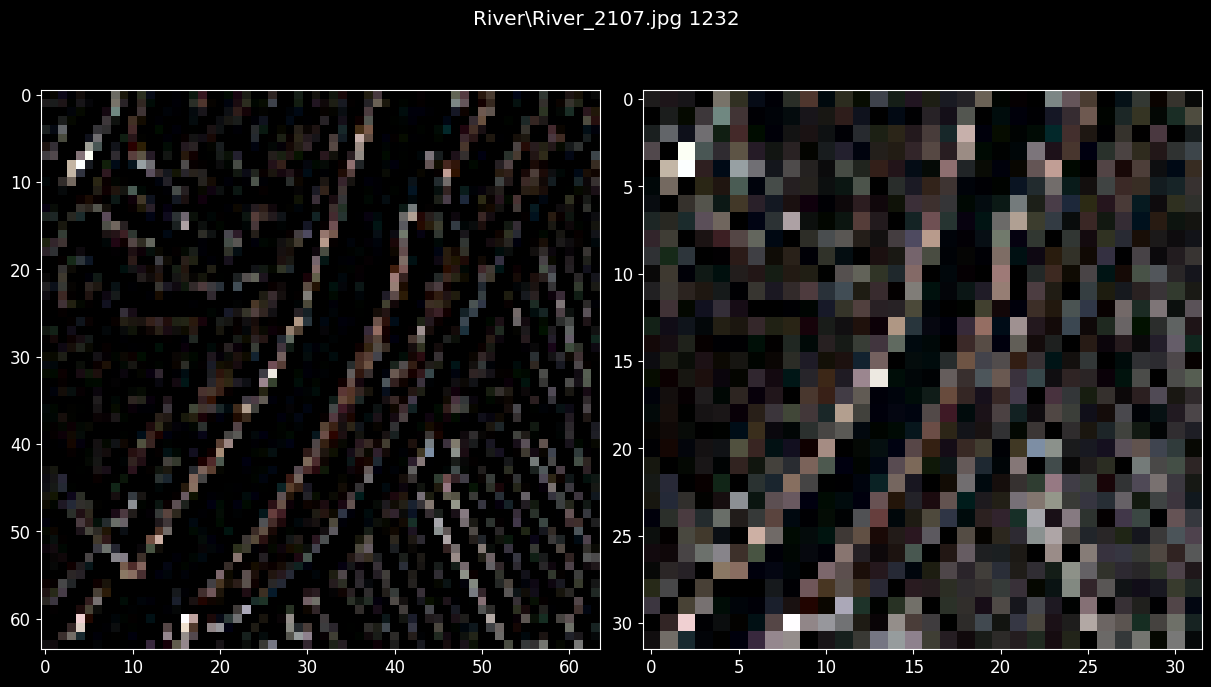

In [46]:
# randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[42]
imgFiltered = myIsoTropicFilter.convolve(imgOrg)
imgPooled = myPoolFilter.downSample(imgFiltered)

plotImgs(imgFiltered,imgPooled)

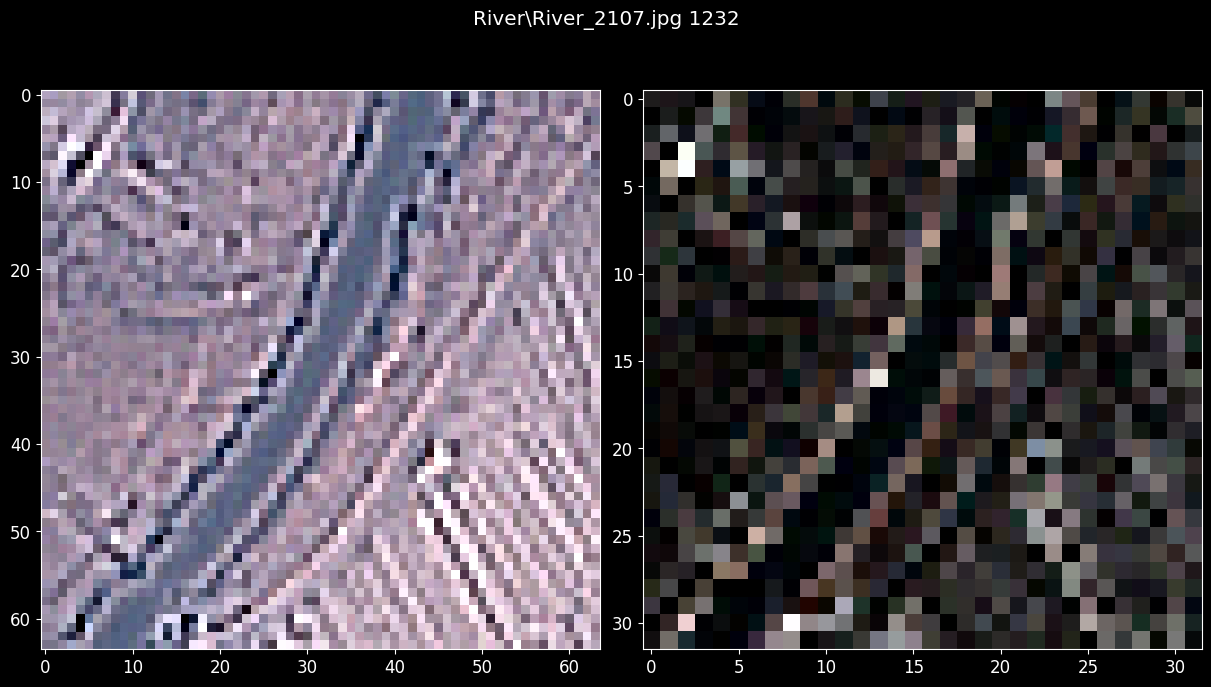

In [47]:
# randInd = random.randint(0, nrOfImages)
imgOrg = imageTensors[42]
imgFiltered = myIsoTropicFilter.convolve(imgOrg)
imgPooled = myPoolFilter.downSample(imgFiltered)

plotImgs(imgOrg-imgFiltered,imgPooled)

In [48]:
print(imgFiltered.shape)

(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

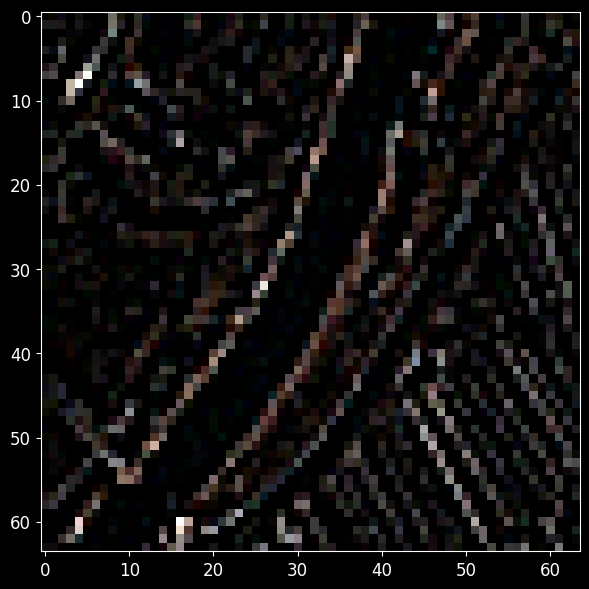

In [49]:
plt.imshow(imgFiltered)
plt.show

# Je ziet dat de image kleiner is. Schrijf hem nu weg als een file en kijk naar de grootte.

<h2>References</h2>

[Image Kernels Explained Visuall - Victor Powell](https://setosa.io/ev/image-kernels/)<br>